In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

# Import custom logger
sys.path.append('..')
from result_logger import log_result

2026-02-02 15:18:22.188942: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 15:18:22.360863: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 15:18:24.109330: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# ============================
# CONFIGURATION
# ============================

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 3

PUBLIC_RAW_DIR = "../Dataset/Public_dataset"
SELF_RAW_DIR = "../Dataset/SelfCollected_Dataset"

os.makedirs("models", exist_ok=True)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.20.0
GPU Available: True


In [5]:
# ============================
# DATA GENERATORS
# ============================

# Public dataset (RAW) – internal split
public_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2   # 80% train, 20% validation
)

train_gen = public_datagen.flow_from_directory(
    PUBLIC_RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = public_datagen.flow_from_directory(
    PUBLIC_RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Self-collected dataset (RAW) – test only
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    SELF_RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n✅ Dataset loading complete")
print(f"Classes: {train_gen.class_indices}")

Found 2148 images belonging to 3 classes.
Found 536 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

✅ Dataset loading complete
Classes: {'aluminium': 0, 'paper': 1, 'plastic': 2}


In [6]:
# ============================
# MODEL ARCHITECTURE
# ============================

base_model = MobileNetV3Large(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze backbone
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

print("\n✅ MobileNetV3-Large model built")
model.summary()

I0000 00:00:1770016731.567993   10349 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



✅ MobileNetV3-Large model built


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,243,139 (12.37 MB)

 Trainable params: 246,787 (964.01 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [7]:
# ============================
# COMPILE MODEL
# ============================

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

print("\n✅ Model compiled successfully")



✅ Model compiled successfully


In [ ]:
# ============================
# CALLBACKS
# ============================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "models/mobilenetv3_TrainTestRaw.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [9]:
# ============================
# TRAINING
# ============================

print("\n🚀 Starting training...\n")

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print("\n✅ Training completed")



🚀 Starting training...

Epoch 1/30


2026-02-02 15:19:00.003924: I external/local_xla/xla/service/service.cc:163] XLA service 0x775318003d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-02 15:19:00.003987: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2026-02-02 15:19:00.338594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-02 15:19:01.988536: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-02-02 15:19:02.305357: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-02 15:19:04.

45/68 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5455 - loss: 1.2332 - precision: 0.5615 - recall: 0.4902

2026-02-02 15:19:32.628077: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3307', 8 bytes spill stores, 8 bytes spill loads

2026-02-02 15:19:42.115099: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 15:19:42.315880: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 15:19:42.513848: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-02 15:19:44.139063: E external/local_xla/xla/stre

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5768 - loss: 1.1297 - precision: 0.5957 - recall: 0.5255

2026-02-02 15:20:02.348430: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1602', 4 bytes spill stores, 4 bytes spill loads

2026-02-02 15:20:02.461291: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1609', 12 bytes spill stores, 12 bytes spill loads

2026-02-02 15:20:02.496534: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1609', 16 bytes spill stores, 16 bytes spill loads

2026-02-02 15:20:02.540386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1602', 8 bytes spill stores, 8 bytes spill loads

2026-02-02 15:20:13.379391: E external/local


Epoch 1: val_accuracy improved from None to 0.83209, saving model to models/mobilenetv3_raw_public.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 819ms/step - accuracy: 0.6657 - loss: 0.8577 - precision: 0.6906 - recall: 0.6234 - val_accuracy: 0.8321 - val_loss: 0.3694 - val_precision: 0.8786 - val_recall: 0.7966 - learning_rate: 1.0000e-04
Epoch 2/30
67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8389 - loss: 0.3818 - precision: 0.8637 - recall: 0.8244
Epoch 2: val_accuracy improved from 0.83209 to 0.90485, saving model to models/mobilenetv3_raw_public.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8459 - loss: 0.3817 - precision: 0.8657 - recall: 0.8315 - val_accuracy: 0.9049 - val_loss: 0.2502 - val_precision: 0.9220 - val_recall: 0.8825 - learning_rate: 1.0000e-04
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9090 - loss: 0.2542 - precision: 0.9199 - recall: 0.8935
Epoch 3: val_accuracy improved from 0.90485 to 0.92724, saving model to models/mobilenet

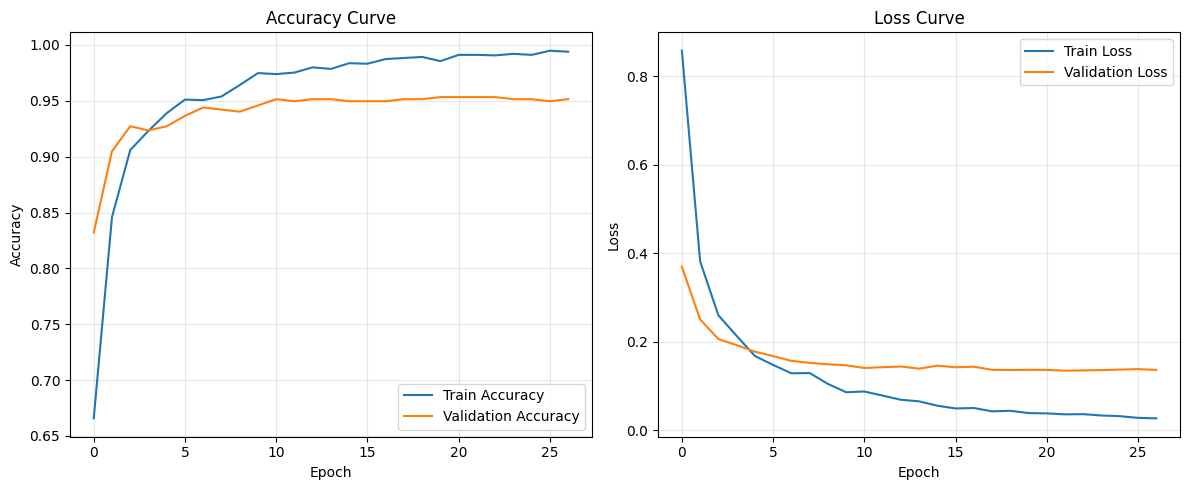

In [10]:
# ============================
# TRAINING CURVES
# ============================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# ============================
# EVALUATION (SELF-COLLECTED)
# ============================

print("\n📊 Evaluating on RAW self-collected dataset...")

test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)

print(f"Test Accuracy:  {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall:    {test_rec*100:.2f}%")
print(f"Test F1-score:  {test_f1*100:.2f}%")


📊 Evaluating on RAW self-collected dataset...


2026-02-02 15:22:00.104248: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1609', 16 bytes spill stores, 16 bytes spill loads

2026-02-02 15:22:00.193888: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1602', 4 bytes spill stores, 4 bytes spill loads

2026-02-02 15:22:00.402296: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1609', 12 bytes spill stores, 12 bytes spill loads

2026-02-02 15:22:00.507179: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1602', 8 bytes spill stores, 8 bytes spill loads

2026-02-02 15:22:10.966725: E external/local

Test Accuracy:  71.86%
Test Precision: 73.11%
Test Recall:    70.92%
Test F1-score:  72.00%


17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 502ms/step

📋 Classification Report
              precision    recall  f1-score   support

   aluminium       0.69      0.75      0.72       148
       paper       0.62      0.76      0.69       151
     plastic       0.84      0.67      0.75       234

    accuracy                           0.72       533
   macro avg       0.72      0.73      0.72       533
weighted avg       0.74      0.72      0.72       533



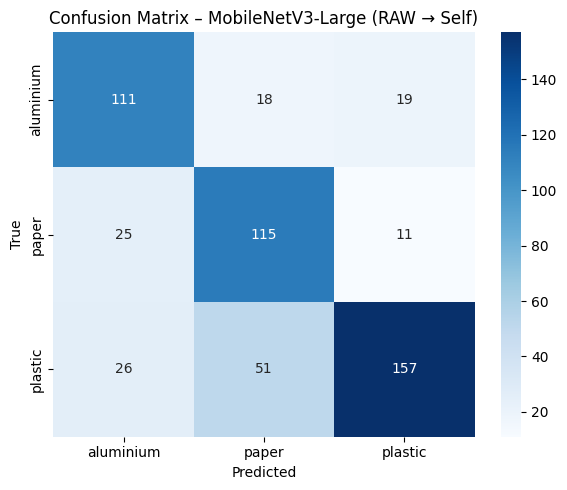


✅ Experiment finished successfully


In [12]:
# ============================
# CONFUSION MATRIX & REPORT
# ============================

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix – MobileNetV3-Large (RAW → Self)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("\n✅ Experiment finished successfully")

# ============================
# LOAD SAVED MODEL (OPTIONAL)
# ============================
If you have already trained the model, load it instead of training again

In [17]:
# Load saved model if it exists
def load_saved_model(model_path):
    """
    Load a saved Keras model
    
    Args:
        model_path: Path to the saved model file
    
    Returns:
        Loaded Keras model or None
    """
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        from tensorflow import keras
        model = keras.models.load_model(model_path)
        print("✓ Model loaded successfully")
        return model
    else:
        print(f"❌ Model not found at {model_path}")
        return None

# Try to load the saved model
model_path = 'models/mobilenetv3_TrainTestRaw.keras'
loaded_model = load_saved_model(model_path)

if loaded_model is not None:
    print("\n📊 Evaluating loaded model on test set...")
    
    # Recreate test generator
    test_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_directory(
        SELF_RAW_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Evaluate
    test_loss, test_acc, test_prec, test_rec = loaded_model.evaluate(test_gen, verbose=1)
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
    
    print(f"\nLoaded Model Results:")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Precision: {test_prec*100:.2f}%")
    print(f"Test Recall: {test_rec*100:.2f}%")
    print(f"Test F1-score: {test_f1*100:.2f}%")
    
    # Log results
    log_result(
        model_name='MobileNetV3-Large',
        experiment_type='Raw',
        accuracy=test_acc,
        precision=test_prec,
        recall=test_rec,
        f1=test_f1,
        loss=test_loss
    )
    
    print("✓ Results logged to final_results.csv")
else:
    print("⚠️ No saved model found. Please train the model first.")

Loading model from models/mobilenetv3_TrainTestRaw.keras
✓ Model loaded successfully

📊 Evaluating loaded model on test set...
Found 533 images belonging to 3 classes.
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 451ms/step - accuracy: 0.7223 - loss: 0.9189 - precision: 0.7297 - recall: 0.7092

Loaded Model Results:
Test Accuracy: 72.23%
Test Precision: 72.97%
Test Recall: 70.92%
Test F1-score: 71.93%
✓ Results logged: MobileNetV3-Large - Raw
  Accuracy: 0.7223, Precision: 0.7297, Recall: 0.7092, F1: 0.7193
✓ Results logged to final_results.csv
